<a href="https://colab.research.google.com/github/rodrigo-koblitz/statsmodels/blob/master/likelihhoXbayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Likelihood vs. Bayesian Estimation in Occupancy–Detectability Ecology

## From Detection Histories to Parameter Inference

**Goal**: Build the likelihood for the single-season occupancy model step by step,
find the MLE, visualise the likelihood surface, then perform full Bayesian inference
with conjugate updates and MCMC.

---

### Ecological context

In wildlife surveys each site is visited $K$ times and a binary record is kept:
- **1** = species detected at visit $j$
- **0** = not detected

The string $(y_1, y_2, \ldots, y_K)$ is the **detection history** of site $i$.

Two processes govern the data:

| Parameter | Symbol | Meaning |
|-----------|--------|---------|
| Occupancy probability | $\psi$ | Prob. a randomly chosen site is occupied |
| Detection probability | $p$ | Prob. of detecting the species in a single visit **given** it is present |

> **Key insight**: A detection = 0 could mean (a) the site is empty, or (b) the species
> was there but missed. Without modelling both $\psi$ and $p$ jointly, naive occupancy
> estimates are always **negatively biased**.


## 1. Setup


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist
from scipy.special import expit          # logistic / sigmoid
import warnings
warnings.filterwarnings('ignore')

rng = np.random.default_rng(42)
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
print('Libraries loaded OK')


Libraries loaded OK


## 2. The Single-Season Occupancy Model

### 2.1 Hierarchical structure

**Process model** — true occupancy state for site $i$:
$$z_i \sim \text{Bernoulli}(\psi)$$

**Observation model** — detection at visit $j$, given occupancy:
$$y_{ij} \mid z_i \sim \text{Bernoulli}(z_i \cdot p)$$

Because $z_i$ is **latent (never directly observed)**, we marginalise it out:

$$
P(\mathbf{y}_i \mid \psi, p) =
\underbrace{\psi \prod_{j=1}^{K} p^{y_{ij}}(1-p)^{1-y_{ij}}}_{\text{occupied}} +
\underbrace{(1-\psi)\,\mathbf{1}[\mathbf{y}_i = \mathbf{0}]}_{\text{unoccupied}}
$$

Note that the unoccupied term is non-zero **only** when all detections are 0.

### 2.2 Likelihood by history type

Let $d_i = \sum_j y_{ij}$ (total detections at site $i$).

| Condition | $P(\mathbf{y}_i \mid \psi, p)$ |
|---|---|
| $d_i > 0$ (at least one detection) | $\psi \cdot p^{d_i}(1-p)^{K-d_i}$ |
| $d_i = 0$ (never detected) | $\psi(1-p)^K + (1-\psi)$ |


## 3. Simulating Detection Histories


In [10]:
# True parameters
PSI_TRUE = 0.70   # 70% of sites are occupied
P_TRUE   = 0.40   # 40% detection probability per visit
N_SITES  = 80     # number of surveyed sites
K_VISITS = 4      # visits per site

# Latent occupancy
z = rng.binomial(1, PSI_TRUE, N_SITES)

# Detection data
Y = rng.binomial(1, P_TRUE * z[:, None], size=(N_SITES, K_VISITS))

# Naive (biased) occupancy estimate
naive_occ = np.mean(Y.any(axis=1))

print(f'True   psi : {PSI_TRUE:.2f}')
print(f'True   p   : {P_TRUE:.2f}')
print(f'Naive occupancy (ever detected, biased): {naive_occ:.2f}')
print(f'\nFirst 10 detection histories:')
for i, row in enumerate(Y[:10]):
    print(f'  Site {i+1:2d}: {''.join(map(str,row))}  '
          f'(d={row.sum()}, true_z={z[i]})')



True   psi : 0.70
True   p   : 0.40
Naive occupancy (ever detected, biased): 0.62

First 10 detection histories:
  Site  1: 0000  (d=0, true_z=0)
  Site  2: 1010  (d=2, true_z=1)
  Site  3: 0000  (d=0, true_z=0)
  Site  4: 0010  (d=1, true_z=1)
  Site  5: 0001  (d=1, true_z=1)
  Site  6: 0000  (d=0, true_z=0)
  Site  7: 0000  (d=0, true_z=0)
  Site  8: 0000  (d=0, true_z=0)
  Site  9: 0001  (d=1, true_z=1)
  Site 10: 0001  (d=1, true_z=1)


## 4. Building the Log-Likelihood

### 4.1 Site-level contribution


In [11]:
def site_prob(psi, p, yi):
    """
    P(yi | psi, p) for a single site.
    yi : 1-D array of 0/1 length K
    """
    d = int(yi.sum())
    K = len(yi)
    occupied_term = psi * (p ** d) * ((1 - p) ** (K - d))
    if d == 0:
        return occupied_term + (1 - psi)
    return occupied_term


def log_likelihood(psi, p, Y):
    """Full log-likelihood over N sites."""
    if not (0 < psi < 1 and 0 < p < 1):
        return -np.inf
    ll = 0.0
    for yi in Y:
        li = site_prob(psi, p, yi)
        ll += np.log(max(li, 1e-300))    # guard against log(0)
        #print(f'yi={yi}; interaction {i}; ll{ll}')
    return ll
yi=Y[1]#[0]np.float64(-3.7705234431544463)
psi=.4
p=.4


# Verify: true params should give higher LL than wrong params
ll_true  = log_likelihood(PSI_TRUE, P_TRUE, Y)
ll_wrong = log_likelihood(0.3, 0.9, Y)
print(f'log-L at true  params ({PSI_TRUE}, {P_TRUE}): {ll_true:.2f}')
print(f'log-L at wrong params (0.3, 0.9):             {ll_wrong:.2f}')
print(f'True params preferred: {ll_true > ll_wrong}')


log-L at true  params (0.7, 0.4): -181.44
log-L at wrong params (0.3, 0.9):             -351.24
True params preferred: True


## 5. Likelihood Surface


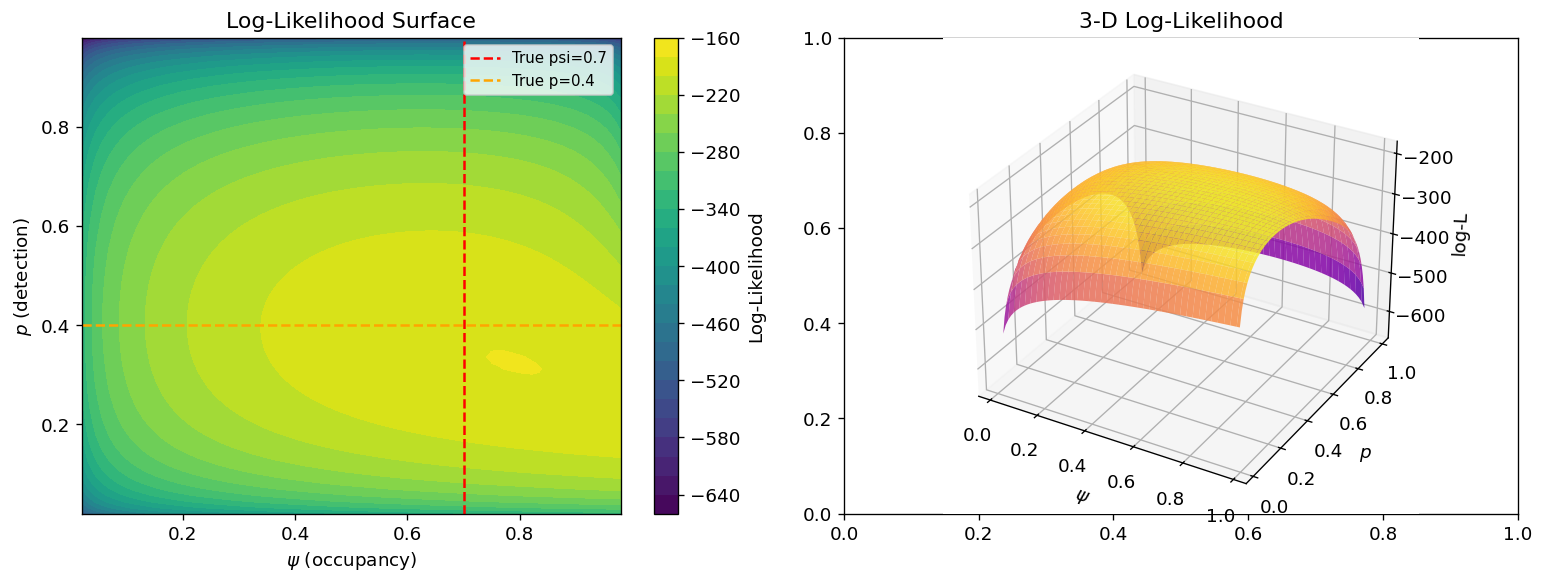

Note the ridge: psi and p are correlated in the likelihood — identifiability
increases with more visits (K) and more sites (N).


In [12]:
grid_n  = 80
psi_vec = np.linspace(0.02, 0.98, grid_n)
p_vec   = np.linspace(0.02, 0.98, grid_n)
PSI_G, P_G = np.meshgrid(psi_vec, p_vec)

LL = np.zeros_like(PSI_G)
for i, pv in enumerate(p_vec):
    for j, pw in enumerate(psi_vec):
        LL[i, j] = log_likelihood(pw, pv, Y)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Contour
cp = axes[0].contourf(PSI_G, P_G, LL, levels=30, cmap='viridis')
fig.colorbar(cp, ax=axes[0], label='Log-Likelihood')
axes[0].set_xlabel(r'$\psi$ (occupancy)')
axes[0].set_ylabel(r'$p$ (detection)')
axes[0].set_title('Log-Likelihood Surface')
axes[0].axvline(PSI_TRUE, color='red', ls='--', label=f'True psi={PSI_TRUE}')
axes[0].axhline(P_TRUE, color='orange', ls='--', label=f'True p={P_TRUE}')
axes[0].legend(fontsize=9)

# 3-D view
ax3 = fig.add_subplot(1, 2, 2, projection='3d')
ax3.plot_surface(PSI_G, P_G, LL, cmap='plasma', alpha=0.85)
ax3.set_xlabel(r'$\psi$')
ax3.set_ylabel(r'$p$')
ax3.set_zlabel('log-L')
ax3.set_title('3-D Log-Likelihood')

plt.tight_layout()
plt.savefig('likelihood_surface.png', dpi=120)
plt.show()
print('Note the ridge: psi and p are correlated in the likelihood — identifiability')
print('increases with more visits (K) and more sites (N).')


## 6. Maximum Likelihood Estimation (MLE)

Minimise $-\ell(\psi, p)$ using L-BFGS-B (handles box constraints on [0,1]).


In [13]:
def neg_ll(params, Y):
    return -log_likelihood(params[0], params[1], Y)

result = minimize(
    neg_ll, x0=[0.5, 0.5], args=(Y,),
    method='L-BFGS-B',
    bounds=[(1e-4, 1-1e-4)] * 2
)

psi_mle, p_mle = result.x
print(f'MLE  psi = {psi_mle:.4f}   (true {PSI_TRUE})')
print(f'MLE  p   = {p_mle:.4f}   (true {P_TRUE})')
print(f'Converged: {result.success}')
print(f'Max log-L: {-result.fun:.3f}')


MLE  psi = 0.7890   (true 0.7)
MLE  p   = 0.3248   (true 0.4)
Converged: True
Max log-L: -179.832


## 7. Profile Likelihood and 95% Confidence Intervals

The **profile likelihood** for $\psi$ is:
$$PL(\psi) = \max_p \; \ell(\psi, p)$$

The 95 % CI is the set of $\psi$ values where:
$$PL(\psi) \geq \ell(\hat{\psi}, \hat{p}) - \tfrac{1}{2}\chi^2_{1,0.05}$$


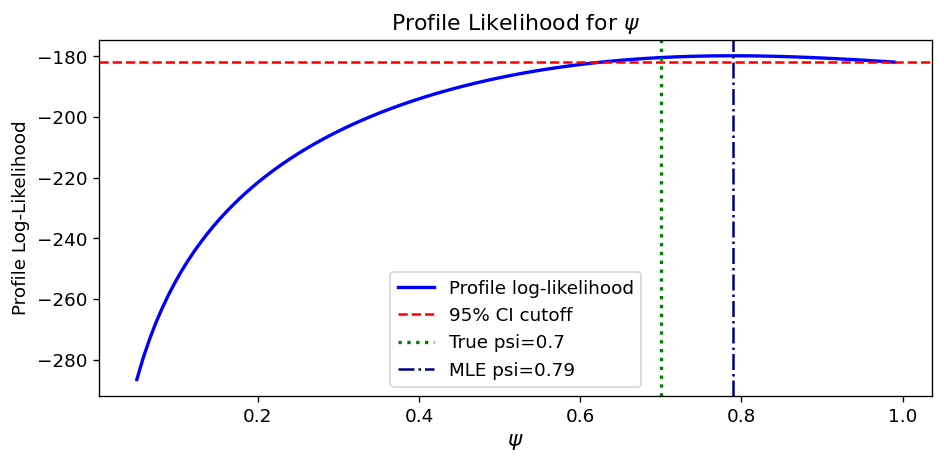

95% Profile-Likelihood CI for psi: [0.635, 0.974]
True psi (0.7) inside CI: True


In [14]:
from scipy.stats import chi2

psi_scan = np.linspace(0.05, 0.99, 120)
pl_psi   = np.zeros(len(psi_scan))

for k, psi_fix in enumerate(psi_scan):
    res_k = minimize(
        lambda p_: -log_likelihood(psi_fix, p_[0], Y),
        x0=[0.5], bounds=[(1e-4, 1-1e-4)]
    )
    pl_psi[k] = -res_k.fun

cutoff = -result.fun - 0.5 * chi2.ppf(0.95, df=1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(psi_scan, pl_psi, 'b-', lw=2, label='Profile log-likelihood')
ax.axhline(cutoff, color='red', ls='--', label='95% CI cutoff')
ax.axvline(PSI_TRUE, color='green', ls=':', lw=2, label=f'True psi={PSI_TRUE}')
ax.axvline(psi_mle, color='navy', ls='-.', label=f'MLE psi={psi_mle:.2f}')
ax.set_xlabel(r'$\psi$', fontsize=13)
ax.set_ylabel('Profile Log-Likelihood')
ax.set_title(r'Profile Likelihood for $\psi$')
ax.legend()
plt.tight_layout()
plt.show()

in_ci   = psi_scan[pl_psi >= cutoff]
ci_lo, ci_hi = in_ci.min(), in_ci.max()
print(f'95% Profile-Likelihood CI for psi: [{ci_lo:.3f}, {ci_hi:.3f}]')
print(f'True psi ({PSI_TRUE}) inside CI: {ci_lo <= PSI_TRUE <= ci_hi}')


Great question! Let me break down the math and intuition behind profile likelihood.

What is a Profile Likelihood?
You have a model with two parameters: ψ (occupancy probability) and p (detection probability). The full log-likelihood is:

$$\ell(\psi, p) = \log L(\psi, p \mid \text{data})$$

The joint MLE finds the pair $(\hat\psi, \hat p)$ that maximizes $\ell(\psi, p)$ simultaneously.

But what if you only care about ψ? The profile log-likelihood for ψ is:

$$\ell_p(\psi) = \max_{p} ; \ell(\psi, p)$$

For each fixed value of ψ, you optimize away the nuisance parameter p — that's exactly what the for loop does:

python
for k, psi_fix in enumerate(psi_scan):
    res_k = minimize(
        lambda p_: -log_likelihood(psi_fix, p_[0], Y),  # fix psi, optimize p
        x0=[0.5], bounds=[(1e-4, 1-1e-4)]
    )
    pl_psi[k] = -res_k.fun  # best log-likelihood achievable for this psi
So pl_psi is a 1D curve — the "ridge" of the 2D likelihood surface, traced along ψ.

Why is the 95% Cutoff Horizontal?
This comes from Wilks' Theorem. It states that when the sample size is large enough:

$$2 \left[ \ell(\hat\psi, \hat p) - \ell_p(\psi) \right] \sim \chi^2_1$$

Rearranging: values of ψ that are statistically compatible with the data at the 95% level must satisfy:

$$\ell(\hat\psi, \hat p) - \ell_p(\psi) \leq \frac{1}{2} \chi^2_{1, 0.95}$$

Which means:

$$\ell_p(\psi) \geq \underbrace{\ell(\hat\psi, \hat p)}{\text{max log-lik}} - \underbrace{\frac{1}{2} \chi^2{1, 0.95}}_{\approx 1.92}$$

in another words:

For a given ψ_fix, the loop:

Finds $\hat{p}(\psi_{\text{fix}}) = \arg\max_p ; \ell(\psi_{\text{fix}}, p)$ — the best p given that ψ is locked
Stores $\ell_p(\psi_{\text{fix}}) = \ell\bigl(\psi_{\text{fix}},; \hat{p}(\psi_{\text{fix}})\bigr)$ — the full log-likelihood evaluated at that pair
So the y-axis value is indeed:

$$\ell_p(\psi) = \ell\bigl(\psi,; \underbrace{\hat{p}(\psi)}_{\text{best } p \text{ for this }\psi}\bigr)$$

One key insight: the profile likelihood cannot be higher than the global MLE, because the global MLE optimizes both simultaneously. The profile curve will:

Peak exactly at $\hat\psi$ (the MLE), where $\hat{p}(\hat\psi)$ coincides with the global $\hat{p}$
Fall off on both sides as you force ψ away from its optimal value, and even the best possible p can't compensate fully
That's why the curve has an inverted-U shape, and the horizontal cutoff naturally carves out the CI as the region where the curve is still "close enough" to the peak.



In code:

python

cutoff = -result.fun - 0.5 * chi2.ppf(0.95, df=1)
`^max log-lik    ^≈ 1.92 threshold`
This is a fixed number (a horizontal line on the plot). The 95% CI is then:

$$\text{CI} = { \psi : \ell_p(\psi) \geq \text{cutoff} }$$

python

in_ci = psi_scan[pl_psi >= cutoff]   # all ψ values above the horizontal cutoff
ci_lo, ci_hi = in_ci.min(), in_ci.max()
Why Horizontal and Not Vertical?
The axis of the plot is ψ (x-axis) vs. profile log-likelihood (y-axis). You're asking: "which values of ψ produce a log-likelihood within 1.92 units of the maximum?"

If the cutoff were vertical	It would mean a fixed ψ value — just selecting a point, not a range
Horizontal cutoff	It selects a range of ψ where the curve stays above the threshold — that range IS the confidence interval
Think of it like slicing a hill: the horizontal line cuts across the hill, and the two intersection points define the CI endpoints.

Summary
Concept	Meaning
Profile likelihood ℓ_p(ψ)	Best log-likelihood achievable at each ψ, after optimizing p away
Horizontal cutoff	Threshold from Wilks' theorem: max log-lik minus ½·χ²₁(0.95) ≈ 1.92
CI endpoints	Where the profile curve crosses the horizontal line
df=1	Because we're constructing a CI for one parameter (ψ)


Detections among confirmed-occupied sites: 82/200


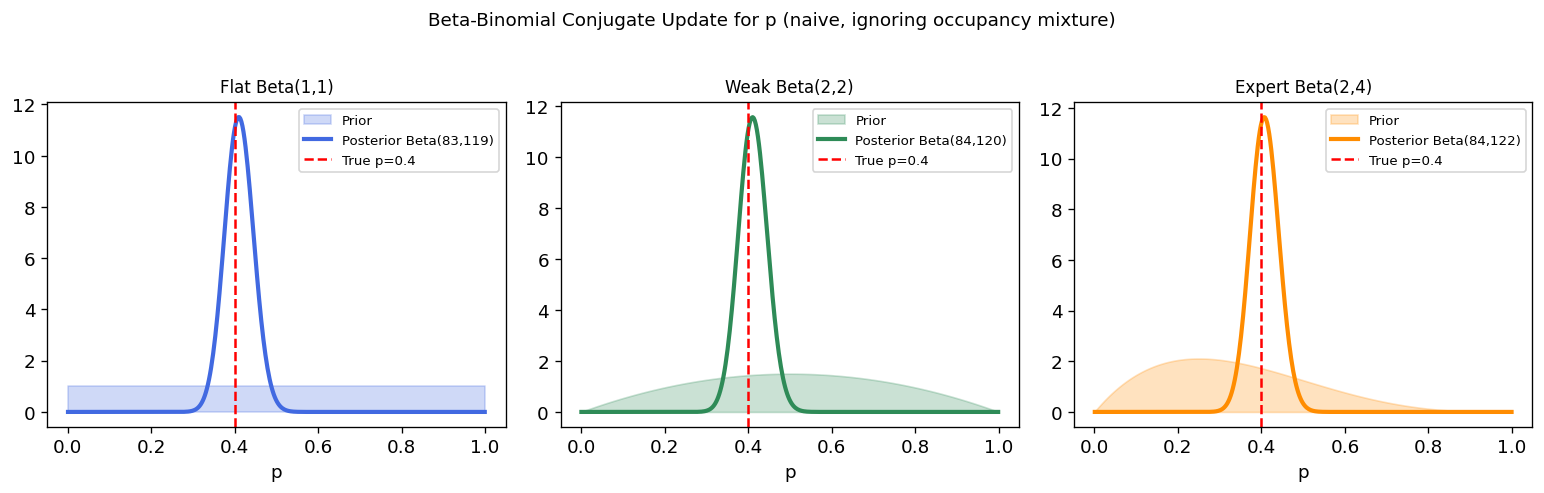

In [15]:
# Detection summary from sites where the species was ever detected
detected_sites = Y[Y.any(axis=1)]
d_total = int(detected_sites.sum())
n_total = detected_sites.size
print(f'Detections among confirmed-occupied sites: {d_total}/{n_total}')

priors = [
    ('Flat Beta(1,1)',        1, 1,  'royalblue'),
    ('Weak Beta(2,2)',        2, 2,  'seagreen'),
    ('Expert Beta(2,4)',      2, 4,  'darkorange'),
]

x = np.linspace(0.001, 0.999, 400)
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for ax, (name, a0, b0, col) in zip(axes, priors):
    a_post = a0 + d_total
    b_post = b0 + n_total - d_total
    ax.fill_between(x, beta_dist.pdf(x, a0, b0),
                    alpha=0.25, color=col, label=f'Prior')
    ax.plot(x, beta_dist.pdf(x, a_post, b_post),
            color=col, lw=2.5, label=f'Posterior Beta({a_post},{b_post})')
    ax.axvline(P_TRUE, color='red', ls='--', lw=1.5, label=f'True p={P_TRUE}')
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('p')
    ax.legend(fontsize=8)

plt.suptitle('Beta-Binomial Conjugate Update for p (naive, ignoring occupancy mixture)',
             fontsize=11, y=1.02)
plt.tight_layout()
plt.show()


## 9. Full Bayesian Inference via Metropolis–Hastings MCMC

Because $\psi$ and $p$ appear in a **mixture likelihood**, there is no conjugate
closed form. We use a **random-walk Metropolis** sampler.

### Log-posterior
$$
\log P(\psi,p \mid \mathbf{Y}) = \ell(\psi,p) +
\log\text{Beta}(\psi; a_\psi, b_\psi) +
\log\text{Beta}(p; a_p, b_p)
$$


In [16]:
def log_prior(psi, p, a_psi=1, b_psi=1, a_p=1, b_p=1):
    if not (0 < psi < 1 and 0 < p < 1):
        return -np.inf
    lp = (a_psi-1)*np.log(psi) + (b_psi-1)*np.log(1-psi)
    lp += (a_p  -1)*np.log(p  ) + (b_p  -1)*np.log(1-p  )
    return lp


def log_posterior(psi, p, Y, a_psi=1, b_psi=1, a_p=1, b_p=1):
    return (log_likelihood(psi, p, Y) +
            log_prior(psi, p, a_psi, b_psi, a_p, b_p))


def mh_sampler(Y, n_iter=30_000, step=0.05,
               a_psi=1, b_psi=1, a_p=1, b_p=1, seed=0):
    """Random-walk Metropolis sampler for (psi, p)."""
    rng_s = np.random.default_rng(seed)
    chain = np.zeros((n_iter, 2))
    cur   = np.array([0.5, 0.5])
    lp_cur = log_posterior(*cur, Y, a_psi, b_psi, a_p, b_p)
    n_acc  = 0

    for i in range(n_iter):
        prop   = cur + rng_s.normal(0, step, 2)
        lp_prop = log_posterior(*prop, Y, a_psi, b_psi, a_p, b_p)
        if np.log(rng_s.uniform()) < lp_prop - lp_cur:
            cur    = prop
            lp_cur = lp_prop
            n_acc += 1
        chain[i] = cur

    print(f'  Acceptance rate: {n_acc/n_iter:.2%}')
    return chain


BURNIN = 5_000

print('=== Flat priors Beta(1,1) x Beta(1,1) ===')
chain_flat = mh_sampler(Y, a_psi=1, b_psi=1, a_p=1, b_p=1)
post_flat  = chain_flat[BURNIN:]

print('=== Informative priors Beta(7,3) x Beta(2,4) ===')
chain_info = mh_sampler(Y, a_psi=7, b_psi=3, a_p=2, b_p=4)
post_info  = chain_info[BURNIN:]


=== Flat priors Beta(1,1) x Beta(1,1) ===
  Acceptance rate: 51.30%
=== Informative priors Beta(7,3) x Beta(2,4) ===
  Acceptance rate: 49.47%


## 10. MCMC Diagnostics and Posterior Summaries


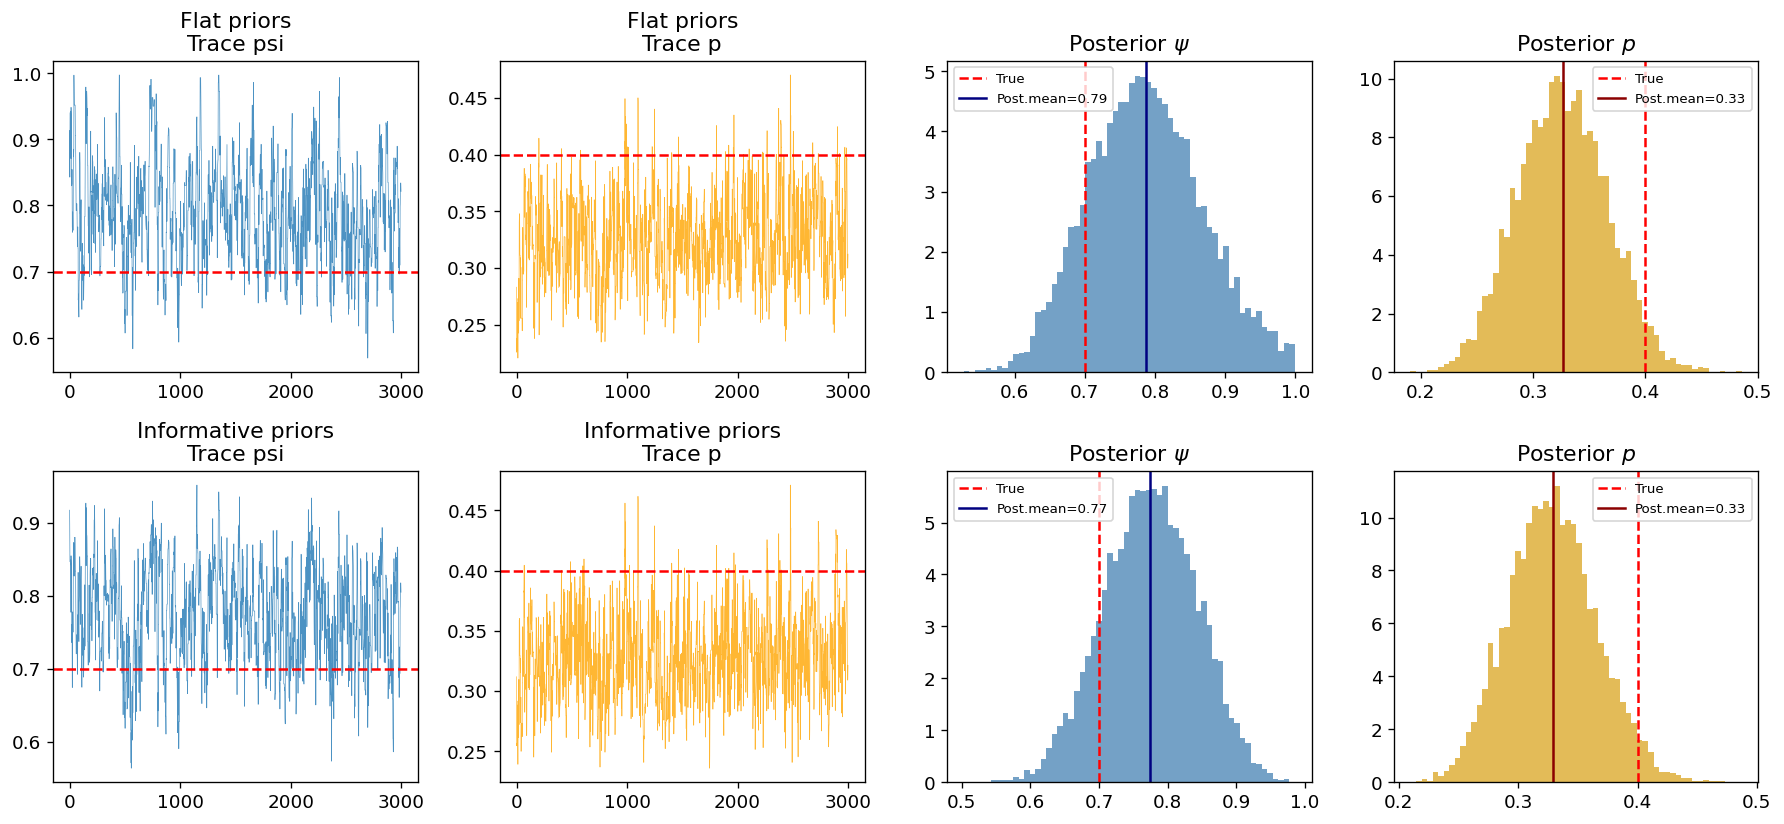


 Param   True     MLE     SE |  FlatMean        Flat95CrI |  InfoMean        Info95CrI
------------------------------------------------------------------------------------------
   psi   0.70   0.789    --- |     0.788 [0.638,0.956]    |     0.774 [0.640,0.904]
     p   0.40   0.325    --- |     0.326 [0.251,0.405]    |     0.329 [0.259,0.404]


In [17]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))

for row, (post, label) in enumerate([(post_flat, 'Flat priors'),
                                      (post_info, 'Informative priors')]):
    psi_s, p_s = post[:, 0], post[:, 1]

    axes[row,0].plot(psi_s[:3000], lw=0.4, alpha=0.8)
    axes[row,0].axhline(PSI_TRUE, color='red', ls='--', lw=1.5)
    axes[row,0].set_title(f'{label}\nTrace psi')

    axes[row,1].plot(p_s[:3000], lw=0.4, alpha=0.8, color='orange')
    axes[row,1].axhline(P_TRUE, color='red', ls='--', lw=1.5)
    axes[row,1].set_title(f'{label}\nTrace p')

    axes[row,2].hist(psi_s, bins=60, density=True, color='steelblue', alpha=0.75)
    axes[row,2].axvline(PSI_TRUE, color='red', ls='--', lw=1.5, label='True')
    axes[row,2].axvline(np.mean(psi_s), color='navy', ls='-',
                        label=f'Post.mean={np.mean(psi_s):.2f}')
    axes[row,2].set_title(r'Posterior $\psi$')
    axes[row,2].legend(fontsize=8)

    axes[row,3].hist(p_s, bins=60, density=True, color='goldenrod', alpha=0.75)
    axes[row,3].axvline(P_TRUE, color='red', ls='--', lw=1.5, label='True')
    axes[row,3].axvline(np.mean(p_s), color='darkred', ls='-',
                        label=f'Post.mean={np.mean(p_s):.2f}')
    axes[row,3].set_title(r'Posterior $p$')
    axes[row,3].legend(fontsize=8)

plt.tight_layout()
plt.savefig('mcmc_posteriors.png', dpi=120)
plt.show()

# Numeric summaries
def cri(s, ci=0.95):
    lo = (1-ci)/2 * 100; hi = (1+ci)/2 * 100
    return np.percentile(s, [lo, hi])

print(f'\n{'Param':>6} {'True':>6} {'MLE':>7} {'SE':>6} | '
      f'{'FlatMean':>9} {'Flat95CrI':>16} | '
      f'{'InfoMean':>9} {'Info95CrI':>16}')
print('-'*90)
for name, true_v, mle_v, sd_v, sf, si in [
    ('psi', PSI_TRUE, psi_mle, 0.0, post_flat[:,0], post_info[:,0]),
    ('p',   P_TRUE,   p_mle,   0.0, post_flat[:,1], post_info[:,1]),
]:
    cf = cri(sf); ci_ = cri(si)
    print(f'{name:>6} {true_v:>6.2f} {mle_v:>7.3f} {'---':>6} | '
          f'{np.mean(sf):>9.3f} [{cf[0]:.3f},{cf[1]:.3f}]    | '
          f'{np.mean(si):>9.3f} [{ci_[0]:.3f},{ci_[1]:.3f}]')


## 11. Prior Sensitivity Analysis

How strongly does the prior choice move the posterior?


In [18]:
configs = [
    ('Flat (1,1)|(1,1)',       1, 1, 1, 1),
    ('Weak (2,2)|(2,2)',       2, 2, 2, 2),
    ('HighOcc (5,2)|(1,1)',    5, 2, 1, 1),
    ('LowDet (1,1)|(1,4)',     1, 1, 1, 4),
    ('Expert (7,3)|(2,4)',     7, 3, 2, 4),
]

print(f'{'Prior':35s} {'E[psi|Y]':>10} {'E[p|Y]':>10}')
print('-'*58)
for name, ap, bp, app, bpp in configs:
    s = mh_sampler(Y, n_iter=20_000, a_psi=ap, b_psi=bp, a_p=app, b_p=bpp)
    s = s[3000:]
    print(f'{name:35s} {np.mean(s[:,0]):10.3f} {np.mean(s[:,1]):10.3f}')

print(f'\nTrue: psi={PSI_TRUE}, p={P_TRUE}')
print(f'MLE:  psi={psi_mle:.3f}, p={p_mle:.3f}')


Prior                                 E[psi|Y]     E[p|Y]
----------------------------------------------------------
  Acceptance rate: 51.12%
Flat (1,1)|(1,1)                         0.793      0.325
  Acceptance rate: 50.71%
Weak (2,2)|(2,2)                         0.766      0.334
  Acceptance rate: 50.18%
HighOcc (5,2)|(1,1)                      0.789      0.326
  Acceptance rate: 50.71%
LowDet (1,1)|(1,4)                       0.803      0.317
  Acceptance rate: 49.31%
Expert (7,3)|(2,4)                       0.777      0.327

True: psi=0.7, p=0.4
MLE:  psi=0.789, p=0.325


## 12. Posterior Site Occupancy Probabilities

A powerful Bayesian output: $P(z_i=1 \mid \mathbf{y}_i, \mathbf{Y})$ — the  
probability that site $i$ is **truly occupied** given its detection history and  
uncertainty in $\psi$ and $p$.

Using Bayes (conditioning on each MCMC draw):

$$
P(z_i=1 \mid \mathbf{y}_i, \psi, p) = \frac{\psi \cdot p^{d_i}(1-p)^{K-d_i}}
{P(\mathbf{y}_i \mid \psi, p)}
$$

Then average over the posterior of $(\psi, p)$.


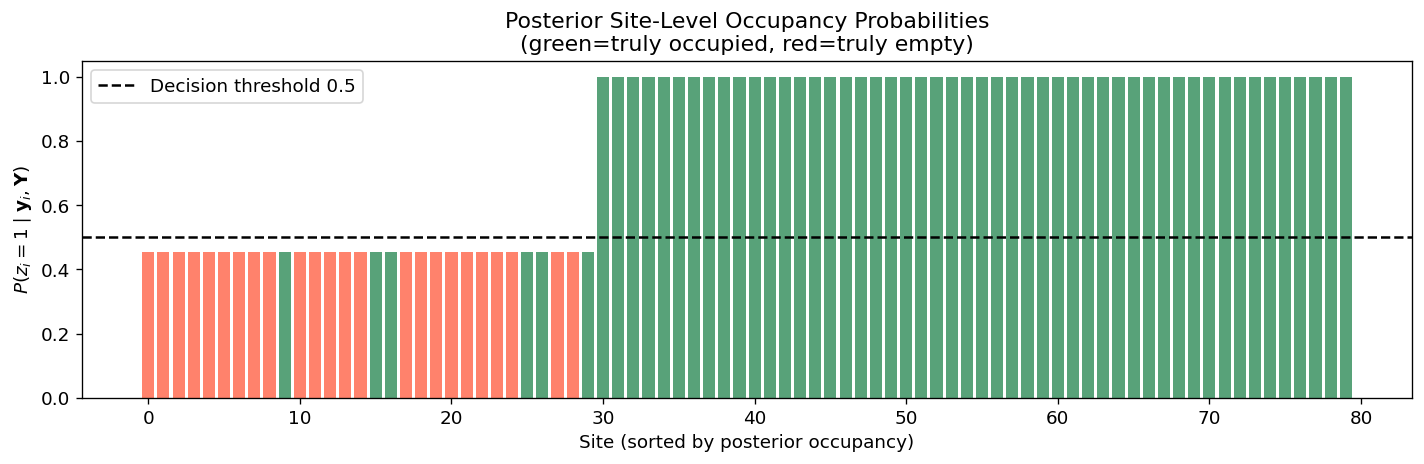

Classification accuracy (threshold 0.5): 92.5%
Sites never detected — correctly classified as uncertain:
  Mean P(z=1) for never-detected sites: 0.454
  (Should be close to the prior psi=0.7 when p is low)


In [19]:
def post_occ_prob(yi, psi_samples, p_samples):
    """P(z=1|yi) integrated over MCMC posterior samples."""
    d = int(yi.sum())
    K = len(yi)
    numer = psi_samples * (p_samples**d) * ((1-p_samples)**(K-d))
    denom = numer.copy()
    if d == 0:
        denom = denom + (1 - psi_samples)
    return float(np.mean(numer / denom))


psi_s = post_flat[:, 0]
p_s   = post_flat[:, 1]

post_occ = np.array([post_occ_prob(Y[i], psi_s, p_s) for i in range(N_SITES)])

# Sort sites by posterior occupancy
order  = np.argsort(post_occ)
colors = ['seagreen' if z[i] else 'tomato' for i in order]

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(N_SITES), post_occ[order], color=colors, edgecolor='none', alpha=0.8)
ax.axhline(0.5, color='black', ls='--', label='Decision threshold 0.5')
ax.set_xlabel('Site (sorted by posterior occupancy)')
ax.set_ylabel(r'$P(z_i=1 \mid \mathbf{y}_i, \mathbf{Y})$')
ax.set_title('Posterior Site-Level Occupancy Probabilities\n'
             '(green=truly occupied, red=truly empty)')
ax.legend()
plt.tight_layout()
plt.savefig('site_occ_posterior.png', dpi=120)
plt.show()

pred_z   = (post_occ >= 0.5).astype(int)
accuracy = np.mean(pred_z == z)
print(f'Classification accuracy (threshold 0.5): {accuracy:.1%}')
print(f'Sites never detected — correctly classified as uncertain:')
never_det = Y.sum(axis=1) == 0
print(f'  Mean P(z=1) for never-detected sites: {post_occ[never_det].mean():.3f}')
print(f'  (Should be close to the prior psi={PSI_TRUE} when p is low)')


## 13. Effect of Survey Design on Estimation Precision

More visits (K) mainly reduce uncertainty in $p$;  
more sites (N) mainly reduce uncertainty in $\psi$.


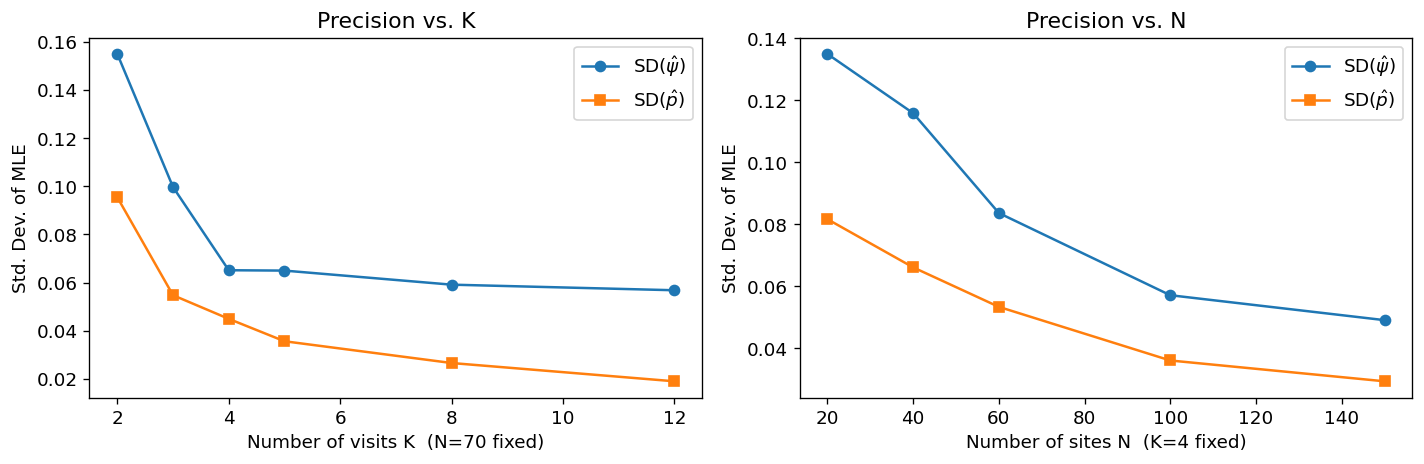

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

K_vals = [2, 3, 4, 5, 8, 12]
psi_sd_K, p_sd_K = [], []
for K_ in K_vals:
    ests = []
    for _ in range(80):
        z_ = rng.binomial(1, PSI_TRUE, 70)
        Y_ = rng.binomial(1, P_TRUE * z_[:,None], size=(70, K_))
        try:
            r_ = minimize(neg_ll, [0.5,0.5], args=(Y_,),
                          method='L-BFGS-B', bounds=[(1e-4,1-1e-4)]*2)
            ests.append(r_.x)
        except: pass
    ests = np.array(ests)
    psi_sd_K.append(np.std(ests[:,0]))
    p_sd_K.append(np.std(ests[:,1]))

axes[0].plot(K_vals, psi_sd_K, 'o-', label=r'SD($\hat{\psi}$)')
axes[0].plot(K_vals, p_sd_K,   's-', label=r'SD($\hat{p}$)')
axes[0].set_xlabel('Number of visits K  (N=70 fixed)')
axes[0].set_ylabel('Std. Dev. of MLE')
axes[0].set_title('Precision vs. K')
axes[0].legend()

N_vals = [20, 40, 60, 100, 150]
psi_sd_N, p_sd_N = [], []
for N_ in N_vals:
    ests = []
    for _ in range(80):
        z_ = rng.binomial(1, PSI_TRUE, N_)
        Y_ = rng.binomial(1, P_TRUE * z_[:,None], size=(N_, 4))
        try:
            r_ = minimize(neg_ll, [0.5,0.5], args=(Y_,),
                          method='L-BFGS-B', bounds=[(1e-4,1-1e-4)]*2)
            ests.append(r_.x)
        except: pass
    ests = np.array(ests)
    psi_sd_N.append(np.std(ests[:,0]))
    p_sd_N.append(np.std(ests[:,1]))

axes[1].plot(N_vals, psi_sd_N, 'o-', label=r'SD($\hat{\psi}$)')
axes[1].plot(N_vals, p_sd_N,   's-', label=r'SD($\hat{p}$)')
axes[1].set_xlabel('Number of sites N  (K=4 fixed)')
axes[1].set_ylabel('Std. Dev. of MLE')
axes[1].set_title('Precision vs. N')
axes[1].legend()

plt.tight_layout()
plt.savefig('design_effect.png', dpi=120)
plt.show()


## 14. Extension: Covariate-Dependent Occupancy and Detection

Real models link $\psi$ and $p$ to covariates via a logistic function:

$$
\text{logit}(\psi_i) = \beta_0 + \beta_1 x_i
\qquad
\text{logit}(p_{ij}) = \alpha_0 + \alpha_1 w_{ij}
$$

This is the standard extension by MacKenzie et al. (2002).


Mean psi (covariate model): 0.41
Mean p   (covariate model): 0.30

Param      True      MLE
-------------------------
b0        -0.50   -0.491
b1         1.20    1.340
a0        -1.00   -0.686
a1         0.80    0.653


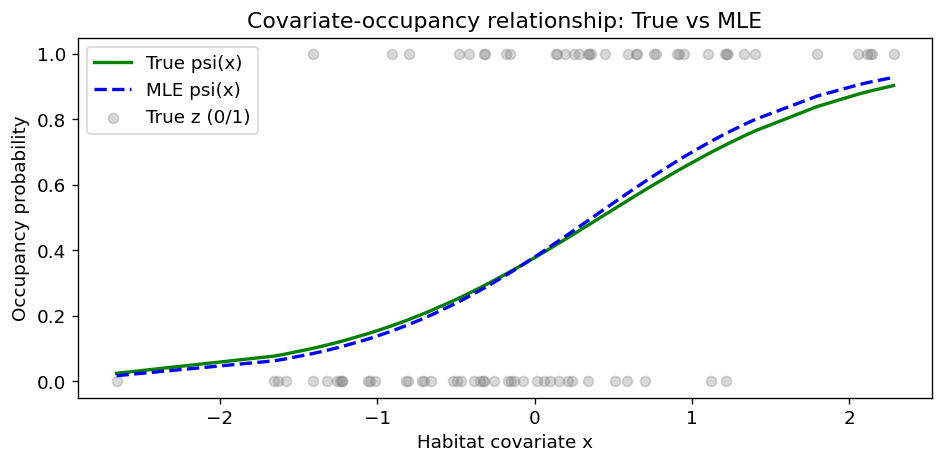

In [21]:
# Simulate with covariates
X_hab  = rng.normal(0, 1, N_SITES)                    # habitat quality
W_wind = rng.normal(0, 1, (N_SITES, K_VISITS))        # wind speed (visit-level)

b0_true, b1_true = -0.5, 1.2
a0_true, a1_true = -1.0, 0.8

psi_cov = expit(b0_true + b1_true * X_hab)
p_cov   = expit(a0_true + a1_true * W_wind)
z_cov   = rng.binomial(1, psi_cov)
Y_cov   = rng.binomial(1, p_cov * z_cov[:, None])

print(f'Mean psi (covariate model): {psi_cov.mean():.2f}')
print(f'Mean p   (covariate model): {p_cov.mean():.2f}')


def neg_ll_cov(params, Y, X, W):
    b0, b1, a0, a1 = params
    psi_i = expit(b0 + b1 * X)
    p_ij  = expit(a0 + a1 * W)
    ll = 0.0
    for i in range(len(Y)):
        yi = Y[i]
        log_p_hist = float(
            np.sum(yi * np.log(p_ij[i] + 1e-15) +
                   (1-yi) * np.log(1-p_ij[i] + 1e-15))
        )
        occ_term = psi_i[i] * np.exp(log_p_hist)
        if yi.sum() == 0:
            li = occ_term + (1 - psi_i[i])
        else:
            li = occ_term
        ll += np.log(max(li, 1e-300))
    return -ll


res_cov = minimize(
    neg_ll_cov, x0=[0., 0., 0., 0.],
    args=(Y_cov, X_hab, W_wind),
    method='L-BFGS-B'
)
b0h, b1h, a0h, a1h = res_cov.x
print(f'\n{'Param':6} {'True':>8} {'MLE':>8}')
print('-'*25)
for nm, tv, mv in [('b0', b0_true, b0h), ('b1', b1_true, b1h),
                   ('a0', a0_true, a0h), ('a1', a1_true, a1h)]:
    print(f'{nm:6} {tv:8.2f} {mv:8.3f}')

# Visualise fitted vs true psi
psi_fit = expit(b0h + b1h * X_hab)
order   = np.argsort(X_hab)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X_hab[order], psi_cov[order], 'g-', lw=2, label='True psi(x)')
ax.plot(X_hab[order], psi_fit[order], 'b--', lw=2, label='MLE psi(x)')
ax.scatter(X_hab, z_cov, alpha=0.3, color='gray', label='True z (0/1)')
ax.set_xlabel('Habitat covariate x')
ax.set_ylabel('Occupancy probability')
ax.set_title('Covariate-occupancy relationship: True vs MLE')
ax.legend()
plt.tight_layout()
plt.show()


## 15. Key Takeaways

### Likelihood perspective
| Step | What we did |
|---|---|
| 1 | Marginalised latent $z_i$ to get $P(\mathbf{y}_i \mid \psi, p)$ |
| 2 | Multiplied site-level contributions → full $\mathcal{L}(\psi,p)$ |
| 3 | Optimised numerically → MLE $\hat{\psi}, \hat{p}$ |
| 4 | Profile likelihood → confidence intervals |

### Bayesian perspective
| Step | What we did |
|---|---|
| 1 | Chose Beta priors for $\psi$ and $p$ |
| 2 | Computed log-posterior = log-prior + log-likelihood |
| 3 | Explored posterior via Metropolis-Hastings MCMC |
| 4 | Obtained full posterior distributions + credible intervals |
| 5 | Computed site-level $P(z_i=1 \mid \mathbf{y}_i, \mathbf{Y})$ |

### When to use which?

| Criterion | Prefer MLE | Prefer Bayes |
|---|---|---|
| Sample size | Large | Small/sparse |
| Prior info available | No | Yes |
| Need full uncertainty? | No (approx. SE) | Yes (posterior) |
| Site-level inference | Harder | Natural output |
| Computation | Fast | MCMC cost |

### Ecological warnings
- **Never use naive occupancy** (ever-detected) as your estimator — it is always biased low.
- **$p = 1$ is unrealistic** for virtually all species; always model detection.
- **More visits per site** trade off against **more sites** — model the likelihood
  surface for your specific $\psi$ and $p$ to find the optimal design.

### References
- MacKenzie et al. (2002). *Estimating site occupancy rates when detection probabilities are less than one.* Ecology 83(8):2248–2255.
- Kéry & Schaub (2011). *Bayesian Population Analysis using WinBUGS.*
- Royle & Dorazio (2008). *Hierarchical Models of Animal Abundance and Occurrence.*
- Gelman et al. (2014). *Bayesian Data Analysis* (3rd ed.)
